In [1]:
import sys
print(sys.executable)
print(sys.version)
!jupyter kernelspec list

E:\python\python.exe
3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Available kernels:
  python3    E:\python\share\jupyter\kernels\python3


In [2]:
import numpy as np
import pandas as pd

E:\python\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
E:\python\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
E:\python\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
teams= pd.read_csv('./teams.csv',header=0)
teams=teams.drop(['Unnamed: 0'],axis=1)
print(teams.shape)
print(teams.head(3))

teams_area= pd.read_csv('./teams_area.csv',header=0)
teams_area=teams_area.drop(['Unnamed: 0'],axis=1)
print(teams_area.shape)
print(teams_area.head(3))

label_tmp = pd.Series(data=teams_area.area).copy()
print(label_tmp.head(3))
v=teams_area.columns
print(v)

(400, 3)
      name        lat         lng
0  中国国家图书馆  39.949641  116.330065
1    首都图书馆  39.875885  116.469182
2   北京图书大厦  39.914075  116.383456
(400, 4)
  area     name        lat         lng
0  海淀区  中国国家图书馆  39.949641  116.330065
1  朝阳区    首都图书馆  39.875885  116.469182
2  西城区   北京图书大厦  39.914075  116.383456
0    海淀区
1    朝阳区
2    西城区
Name: area, dtype: object
Index(['area', 'name', 'lat', 'lng'], dtype='object')


In [4]:
process_tmp=[]
for index, value in label_tmp.items():
        if value == "海淀区" :#or value == "朝阳区" or value == "东城区" or value == "西城区":#提取出某天pm2.5了
            zero_tmp=teams_area.iloc[index].copy().values
            process_tmp.append(zero_tmp)
zero_tmp=pd.DataFrame(process_tmp,columns=v)
zero_tmp.head(5)
            #zero_tmp=array[j].iloc[index].copy().values#矩阵
            #process_tmp.append(zero_tmp)
            #东城区31、西城区43、朝阳区127、丰台区18、石景山区5、海淀区95

,area,name,lat,lng
0,海淀区,中国国家图书馆,39.949641,116.330065
1,海淀区,海淀区图书馆,39.984178,116.315950
2,海淀区,中国科学院文献情报中心,39.993046,116.329603
3,海淀区,清华大学法律图书馆楼,40.005203,116.335359
4,海淀区,北京大学-图书馆,39.997899,116.316801


In [5]:
length=int(zero_tmp.shape[0])
print(length)
print(teams_area.shape)
print(teams.shape)

94
(400, 4)
(400, 3)


In [6]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Windows 64bit
* Python version 3.7.4, located at: E:\python\python.exe
* docplex is present, version is (2, 11, 176)
* CPLEX library is present, version is 12.9.0.0, located at: E:\cplex2019\cplex\python\3.7\x64_win64
* pandas is present, version is 0.25.2


In [7]:
# Store longitude, latitude and street crossing name of each public library location.
class XPoint(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __str__(self):
        return "P(%g_%g)" % (self.x, self.y)

class NamedPoint(XPoint):
    def __init__(self, name, x, y):
        XPoint.__init__(self, x, y)
        self.name = name
    def __str__(self):
        return self.name

In [8]:
from geopy.distance import great_circle
 
def get_distance(p1, p2):
    return great_circle((p1.x, p1.y), (p2.x, p2.y)).miles

In [9]:
libraries = []
for i in range(0,length):
    cp = NamedPoint(zero_tmp.iloc[i,1], zero_tmp.iloc[i,2], zero_tmp.iloc[i,3])
    libraries.append(cp)
#libraries #中括号和大括号差别
libraries = set(libraries)
#print(libraries)
#libraries
coffeeshop_locations = libraries

for c_loc in coffeeshop_locations:
    for b in libraries:
        #print(c_loc.x)
        get_distance(c_loc, b)
print(get_distance(c_loc, b))
print(c_loc.x)
print(c_loc.y)
print(c_loc.name) #这段落和上段落每次跑都不一样不知道原因

0.0
39.998763000000004
116.315956
阿卜杜勒·阿齐兹国王公共图书馆北京大学分馆暨北大古籍图书馆


In [10]:
from docplex.mp.model import Model
mdl = Model("coffee shops")

In [11]:
coffeeshop_vars = mdl.binary_var_dict(coffeeshop_locations, name="is_coffeeshop")
#print(coffeeshop_vars)
link_vars = mdl.binary_var_matrix(coffeeshop_locations, libraries, "link")
#print(link_vars)

In [12]:
BIGNUM = 999999999
for c_loc in coffeeshop_locations:
    for b in libraries:
        if get_distance(c_loc, b) >= BIGNUM:
            mdl.add_constraint(link_vars[c_loc, b] == 0, "ct_forbid_{0!s}_{1!s}".format(c_loc, b))
#-------------------------------------------------------------------------------------------------------------------            
mdl.add_constraints(link_vars[c_loc, b] <= coffeeshop_vars[c_loc]
                   for b in libraries
                   for c_loc in coffeeshop_locations)
#mdl.print_information() 
#-------------------------------------------------------------------------------------------------------------------
mdl.add_constraints(mdl.sum(link_vars[c_loc, b] for c_loc in coffeeshop_locations) == 1
                   for b in libraries)
#mdl.print_information()
#-------------------------------------------------------------------------------------------------------------------
# Total nb of open coffee shops
mdl.add_constraint(mdl.sum(coffeeshop_vars[c_loc] for c_loc in coffeeshop_locations) == 5)
# Print model information
#mdl.print_information()
#print(mdl.export_to_string())
#-------------------------------------------------------------------------------------------------------------------
# Minimize total distance from points to hubs
total_distance = mdl.sum(link_vars[c_loc, b] * get_distance(c_loc, b) for c_loc in coffeeshop_locations for b in libraries)
mdl.minimize(total_distance)
#-------------------------------------------------------------------------------------------------------------------
nb_shops=5
print("# coffee shops locations = %d" % len(coffeeshop_locations))
print("# coffee shops           = %d" % nb_shops)

assert mdl.solve(), "!!! Solve of the model fails"
solucion=mdl.solve(log_output=True)

# coffee shops locations = 94
# coffee shops           = 5
CPXPARAM_Read_DataCheck                          1
4 of 4 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 124.7306.
Tried aggregator 1 time.
Reduced MIP has 8931 rows, 8930 columns, and 26602 nonzeros.
Reduced MIP has 8930 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (41.09 ticks)
Probing time = 0.00 sec. (4.88 ticks)
Tried aggregator 1 time.
Reduced MIP has 8931 rows, 8930 columns, and 26602 nonzeros.
Reduced MIP has 8930 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (44.57 ticks)
Probing time = 0.01 sec. (4.88 ticks)
Clique table members: 8930.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.13 sec. (74.49 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Be

In [13]:
total_distance = mdl.objective_value
open_coffeeshops = [c_loc for c_loc in coffeeshop_locations if coffeeshop_vars[c_loc].solution_value == 1]
not_coffeeshops = [c_loc for c_loc in coffeeshop_locations if c_loc not in open_coffeeshops]
edges = [(c_loc, b) for b in libraries for c_loc in coffeeshop_locations if int(link_vars[c_loc, b]) == 1]

print("Total distance = %g" % total_distance)
print("# coffee shops  = {0}".format(len(open_coffeeshops)))
latzero=[]
lngzero=[]
for c in open_coffeeshops:
    print("new coffee shop: {0!s}".format(c))
    latzero.append(c.x)
    lngzero.append(c.y)
    print("lat:%g"%c.x)
    print("lng:%g"%c.y)
print(latzero)
print(lngzero)

Total distance = 124.731
# coffee shops  = 5
new coffee shop: 北京电影学院-图书馆
lat:39.9781
lng:116.363
new coffee shop: 微澜图书馆第14馆
lat:40.0679
lng:116.217
new coffee shop: 气味图书馆(欧美汇购物中心)
lat:39.9852
lng:116.321
new coffee shop: 首都师范大学北一区图书馆(国际文化大厦西北)
lat:39.9438
lng:116.315
new coffee shop: 清华大学图书馆-李文正馆
lat:40.0114
lng:116.331
[39.978125, 40.067948, 39.985215999999994, 39.943826, 40.011369]
[116.363028, 116.21738799999999, 116.32088799999998, 116.31469299999999, 116.330721]


In [15]:
team1 = pd.DataFrame(latzero)
team2 = pd.DataFrame(lngzero)
team1.columns = ["lat"]
team2.columns = ["lng"]
hidea_cplex_solve = pd.concat([team1,team2], axis=1)
hidea_cplex_solve
hidea_cplex_solve.to_csv('./hidea_cplex_solve.csv')


In [16]:
ltset_hidea=[]
lgset_hidea=[]
for coffeeshop in open_coffeeshops:
    ltset_hidea.append(coffeeshop.x)
    lgset_hidea.append(coffeeshop.y)
print(ltset_hidea)
print(lgset_hidea)
#-------------------------------------------------------------------------------------------------------------------
ltorigin_hidea=[]
lgorigin_hidea=[]
for b in libraries:
    if b not in open_coffeeshops:
        ltorigin_hidea.append(b.x)
        lgorigin_hidea.append(b.y)
print(len(ltorigin_hidea))
print(lgorigin_hidea)
#-------------------------------------------------------------------------------------------------------------------
c_x_edge_hidea=[]
c_y_edge_hidea=[]
b_x_edge_hidea=[]
b_y_edge_hidea=[]
for (c, b) in edges:
    c_x_edge_hidea.append(c.x)
    c_y_edge_hidea.append(c.y)
    b_x_edge_hidea.append(b.x)
    b_y_edge_hidea.append(b.y)

[39.978125, 40.067948, 39.985215999999994, 39.943826, 40.011369]
[116.363028, 116.21738799999999, 116.32088799999998, 116.31469299999999, 116.330721]
89
[116.29250400000001, 116.27833999999999, 116.262363, 116.35495, 116.36418300000001, 116.315909, 116.301754, 116.327797, 116.3097, 116.294402, 116.31591599999999, 116.31248400000001, 116.320278, 116.319511, 116.22678, 116.33057099999999, 116.352653, 116.33703600000001, 116.31331499999999, 116.356369, 116.32500300000001, 116.358127, 116.37508600000001, 116.30318500000001, 116.33055300000001, 116.317898, 116.28876899999999, 116.35354199999999, 116.353443, 116.32137, 116.329916, 116.32431100000001, 116.294851, 116.34653300000001, 116.337452, 116.124485, 116.31691699999999, 116.34836200000001, 116.32904599999999, 116.33641999999999, 116.337129, 116.314355, 116.31476699999999, 116.29760900000001, 116.29466699999999, 116.33006499999999, 116.323748, 116.371669, 116.31595, 116.283775, 116.330749, 116.329603, 116.329811, 116.33073600000002, 116.

In [17]:
import folium
map_osm = folium.Map(location=[39.992, 116.32], zoom_start=12)
for i in range(0,len(ltset_hidea)):
    folium.Marker([ltset_hidea[i], lgset_hidea[i]], icon=folium.Icon(color='red',icon='info-sign')).add_to(map_osm)

for i in range(0,len(ltorigin_hidea)):
    folium.Marker([ltorigin_hidea[i], lgorigin_hidea[i]],icon=folium.Icon(color='gray',icon='cloud')).add_to(map_osm)

for i in range(0,len(c_x_edge_hidea)):
    coordinates = [[c_x_edge_hidea[i], c_y_edge_hidea[i]], [b_x_edge_hidea[i],b_y_edge_hidea[i]]]
    map_osm.add_child(folium.PolyLine(coordinates, color='darkorange', weight=5))
map_osm

In [18]:
save_lt_hidea=ltset_hidea
save_lg_hidea=lgset_hidea
print(save_lt_hidea)
print(save_lg_hidea)

[39.978125, 40.067948, 39.985215999999994, 39.943826, 40.011369]
[116.363028, 116.21738799999999, 116.32088799999998, 116.31469299999999, 116.330721]


In [19]:
process_tmp=[]
for index, value in label_tmp.items():
        if  value == "东城区" or value == "西城区":#提取出某天pm2.5了
            zero_tmp=teams_area.iloc[index].copy().values
            process_tmp.append(zero_tmp)
zero_tmp=pd.DataFrame(process_tmp,columns=v)
zero_tmp.head(5)
            #zero_tmp=array[j].iloc[index].copy().values#矩阵
            #process_tmp.append(zero_tmp)
            #东城区31、西城区43、朝阳区127、丰台区18、石景山区5、海淀区95

,area,name,lat,lng
0,西城区,北京图书大厦,39.914075,116.383456
1,西城区,西城区青少年儿童图书馆,39.947947,116.376640
2,西城区,红楼公共藏书楼,39.928127,116.380154
3,西城区,西城区第二图书馆,39.894226,116.374833
4,东城区,角楼图书馆,39.878040,116.449567


In [20]:
length=int(zero_tmp.shape[0])
print(length)
print(teams_area.shape)
print(teams.shape)

74
(400, 4)
(400, 3)


In [21]:
libraries = []
for i in range(0,length):
    cp = NamedPoint(zero_tmp.iloc[i,1], zero_tmp.iloc[i,2], zero_tmp.iloc[i,3])
    libraries.append(cp)
#libraries #中括号和大括号差别
libraries = set(libraries)
#print(libraries)
#libraries
coffeeshop_locations = libraries

for c_loc in coffeeshop_locations:
    for b in libraries:
        #print(c_loc.x)
        get_distance(c_loc, b)
print(get_distance(c_loc, b))
print(c_loc.x)
print(c_loc.y)
print(c_loc.name) #这段落和上段落每次跑都不一样不知道原因

0.0
39.903158000000005
116.43481200000001
阅有意思(崇文门馆)


In [22]:
from docplex.mp.model import Model
mdl = Model("coffee shops")

In [23]:
coffeeshop_vars = mdl.binary_var_dict(coffeeshop_locations, name="is_coffeeshop")
#print(coffeeshop_vars)
link_vars = mdl.binary_var_matrix(coffeeshop_locations, libraries, "link")
#print(link_vars)

In [24]:
BIGNUM = 999999999
for c_loc in coffeeshop_locations:
    for b in libraries:
        if get_distance(c_loc, b) >= BIGNUM:
            mdl.add_constraint(link_vars[c_loc, b] == 0, "ct_forbid_{0!s}_{1!s}".format(c_loc, b))
#-------------------------------------------------------------------------------------------------------------------            
mdl.add_constraints(link_vars[c_loc, b] <= coffeeshop_vars[c_loc]
                   for b in libraries
                   for c_loc in coffeeshop_locations)
#mdl.print_information() 
#-------------------------------------------------------------------------------------------------------------------
mdl.add_constraints(mdl.sum(link_vars[c_loc, b] for c_loc in coffeeshop_locations) == 1
                   for b in libraries)
#mdl.print_information()
#-------------------------------------------------------------------------------------------------------------------
# Total nb of open coffee shops
mdl.add_constraint(mdl.sum(coffeeshop_vars[c_loc] for c_loc in coffeeshop_locations) == 5)
# Print model information
#mdl.print_information()
#print(mdl.export_to_string())
#-------------------------------------------------------------------------------------------------------------------
# Minimize total distance from points to hubs
total_distance = mdl.sum(link_vars[c_loc, b] * get_distance(c_loc, b) for c_loc in coffeeshop_locations for b in libraries)
mdl.minimize(total_distance)
#-------------------------------------------------------------------------------------------------------------------
nb_shops=5
print("# coffee shops locations = %d" % len(coffeeshop_locations))
print("# coffee shops           = %d" % nb_shops)

assert mdl.solve(), "!!! Solve of the model fails"
solucion=mdl.solve(log_output=True)

# coffee shops locations = 74
# coffee shops           = 5
CPXPARAM_Read_DataCheck                          1
4 of 4 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 76.3128.
Tried aggregator 1 time.
Reduced MIP has 5551 rows, 5550 columns, and 16502 nonzeros.
Reduced MIP has 5550 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (22.62 ticks)
Probing time = 0.02 sec. (3.90 ticks)
Tried aggregator 1 time.
Reduced MIP has 5551 rows, 5550 columns, and 16502 nonzeros.
Reduced MIP has 5550 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (24.78 ticks)
Probing time = 0.02 sec. (3.90 ticks)
Clique table members: 5550.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.06 sec. (46.27 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Bes

In [25]:
total_distance = mdl.objective_value
open_coffeeshops = [c_loc for c_loc in coffeeshop_locations if coffeeshop_vars[c_loc].solution_value == 1]
not_coffeeshops = [c_loc for c_loc in coffeeshop_locations if c_loc not in open_coffeeshops]
edges = [(c_loc, b) for b in libraries for c_loc in coffeeshop_locations if int(link_vars[c_loc, b]) == 1]

print("Total distance = %g" % total_distance)
print("# coffee shops  = {0}".format(len(open_coffeeshops)))
latzero=[]
lngzero=[]
for c in open_coffeeshops:
    print("new coffee shop: {0!s}".format(c))
    latzero.append(c.x)
    lngzero.append(c.y)
    print("lat:%g"%c.x)
    print("lng:%g"%c.y)
print(latzero)
print(lngzero)

Total distance = 76.3128
# coffee shops  = 5
new coffee shop: 和平里街道兴化社区-图书馆
lat:39.966
lng:116.417
new coffee shop: 西城区图书馆(月坛街道分馆)
lat:39.9209
lng:116.353
new coffee shop: 中国盲文图书馆
lat:39.8874
lng:116.394
new coffee shop: 北京图书馆主楼
lat:39.9289
lng:116.392
new coffee shop: 阅有意思(崇文门馆)
lat:39.9032
lng:116.435
[39.965986, 39.920857, 39.887391, 39.928927, 39.903158000000005]
[116.416827, 116.35304099999999, 116.39431499999999, 116.391726, 116.43481200000001]


In [26]:
team1 = pd.DataFrame(latzero)
team2 = pd.DataFrame(lngzero)
team1.columns = ["lat"]
team2.columns = ["lng"]
wall_cplex_solve = pd.concat([team1,team2], axis=1)
wall_cplex_solve
wall_cplex_solve.to_csv('./wall_cplex_solve.csv')

In [27]:
ltset_wall=[]
lgset_wall=[]
for coffeeshop in open_coffeeshops:
    ltset_wall.append(coffeeshop.x)
    lgset_wall.append(coffeeshop.y)
print(ltset_wall)
print(lgset_wall)
#-------------------------------------------------------------------------------------------------------------------
ltorigin_wall=[]
lgorigin_wall=[]
for b in libraries:
    if b not in open_coffeeshops:
        ltorigin_wall.append(b.x)
        lgorigin_wall.append(b.y)
print(len(ltorigin_wall))
print(lgorigin_wall)
#-------------------------------------------------------------------------------------------------------------------
c_x_edge_wall=[]
c_y_edge_wall=[]
b_x_edge_wall=[]
b_y_edge_wall=[]
for (c, b) in edges:
    c_x_edge_wall.append(c.x)
    c_y_edge_wall.append(c.y)
    b_x_edge_wall.append(b.x)
    b_y_edge_wall.append(b.y)

[39.965986, 39.920857, 39.887391, 39.928927, 39.903158000000005]
[116.416827, 116.35304099999999, 116.39431499999999, 116.391726, 116.43481200000001]
69
[116.406951, 116.38345600000001, 116.38891699999999, 116.385846, 116.37664, 116.45421, 116.43916599999999, 116.383447, 116.34173600000001, 116.410974, 116.391469, 116.420547, 116.380154, 116.393808, 116.353071, 116.42403200000001, 116.418521, 116.42436399999998, 116.41721000000001, 116.438148, 116.40681599999999, 116.37659, 116.37483300000001, 116.342626, 116.43505400000001, 116.371525, 116.38126799999999, 116.415631, 116.412502, 116.36501299999999, 116.395678, 116.44956699999999, 116.349014, 116.44313899999999, 116.37955600000001, 116.363133, 116.39730800000001, 116.43371599999999, 116.36039099999999, 116.392886, 116.37642199999999, 116.378175, 116.43588799999999, 116.38361599999999, 116.409924, 116.45076399999999, 116.334943, 116.427568, 116.348321, 116.36842800000001, 116.42767099999999, 116.410372, 116.39166999999999, 116.374571, 1

In [28]:
for i in range(0,len(ltset_wall)):
    folium.Marker([ltset_wall[i], lgset_wall[i]], icon=folium.Icon(color='blue',icon='info-sign')).add_to(map_osm)
    
for i in range(0,len(ltorigin_wall)):
    folium.Marker([ltorigin_wall[i], lgorigin_wall[i]],icon=folium.Icon(color='cadetblue',icon='cloud')).add_to(map_osm)
    
for i in range(0,len(c_x_edge_wall)):
    coordinates = [[c_x_edge_wall[i], c_y_edge_wall[i]], [b_x_edge_wall[i],b_y_edge_wall[i]]]
    map_osm.add_child(folium.PolyLine(coordinates, color='darkgreen', weight=5))
map_osm    

In [29]:
save_lt_wall=ltset_wall
save_lg_wall=lgset_wall
print(save_lt_wall)
print(save_lg_wall)

[39.965986, 39.920857, 39.887391, 39.928927, 39.903158000000005]
[116.416827, 116.35304099999999, 116.39431499999999, 116.391726, 116.43481200000001]


In [30]:
process_tmp=[]
for index, value in label_tmp.items():
        if  value == "朝阳区" :#提取出某天pm2.5了
            zero_tmp=teams_area.iloc[index].copy().values
            process_tmp.append(zero_tmp)
zero_tmp=pd.DataFrame(process_tmp,columns=v)
zero_tmp.head(5)
            #zero_tmp=array[j].iloc[index].copy().values#矩阵
            #process_tmp.append(zero_tmp)
            #东城区31、西城区43、朝阳区127、丰台区18、石景山区5、海淀区95

,area,name,lat,lng
0,朝阳区,首都图书馆,39.875885,116.469182
1,朝阳区,朝阳区图书馆(朝外小庄店),39.922647,116.477617
2,朝阳区,杂书馆(国学馆),40.043519,116.499623
3,朝阳区,朝阳区少儿图书馆,39.974269,116.407531
4,朝阳区,北京市朝阳区望京街道图书馆,40.000093,116.475464


In [31]:
length=int(zero_tmp.shape[0])
print(length)
print(teams_area.shape)
print(teams.shape)

127
(400, 4)
(400, 3)


In [32]:
libraries = []
for i in range(0,length):
    cp = NamedPoint(zero_tmp.iloc[i,1], zero_tmp.iloc[i,2], zero_tmp.iloc[i,3])
    libraries.append(cp)
#libraries #中括号和大括号差别
libraries = set(libraries)
#print(libraries)
#libraries
coffeeshop_locations = libraries

for c_loc in coffeeshop_locations:
    for b in libraries:
        #print(c_loc.x)
        get_distance(c_loc, b)
print(get_distance(c_loc, b))
print(c_loc.x)
print(c_loc.y)
print(c_loc.name) #这段落和上段落每次跑都不一样不知道原因

0.0
39.977734000000005
116.435073
北京中医药大学-图书馆


In [33]:
from docplex.mp.model import Model
mdl = Model("coffee shops")

In [34]:
coffeeshop_vars = mdl.binary_var_dict(coffeeshop_locations, name="is_coffeeshop")
#print(coffeeshop_vars)
link_vars = mdl.binary_var_matrix(coffeeshop_locations, libraries, "link")
#print(link_vars)

In [35]:
BIGNUM = 999999999
for c_loc in coffeeshop_locations:
    for b in libraries:
        if get_distance(c_loc, b) >= BIGNUM:
            mdl.add_constraint(link_vars[c_loc, b] == 0, "ct_forbid_{0!s}_{1!s}".format(c_loc, b))
#-------------------------------------------------------------------------------------------------------------------            
mdl.add_constraints(link_vars[c_loc, b] <= coffeeshop_vars[c_loc]
                   for b in libraries
                   for c_loc in coffeeshop_locations)
#mdl.print_information() 
#-------------------------------------------------------------------------------------------------------------------
mdl.add_constraints(mdl.sum(link_vars[c_loc, b] for c_loc in coffeeshop_locations) == 1
                   for b in libraries)
#mdl.print_information()
#-------------------------------------------------------------------------------------------------------------------
# Total nb of open coffee shops
mdl.add_constraint(mdl.sum(coffeeshop_vars[c_loc] for c_loc in coffeeshop_locations) == 7)
# Print model information
#mdl.print_information()
#print(mdl.export_to_string())
#-------------------------------------------------------------------------------------------------------------------
# Minimize total distance from points to hubs
total_distance = mdl.sum(link_vars[c_loc, b] * get_distance(c_loc, b) for c_loc in coffeeshop_locations for b in libraries)
mdl.minimize(total_distance)
#-------------------------------------------------------------------------------------------------------------------
nb_shops=7
print("# coffee shops locations = %d" % len(coffeeshop_locations))
print("# coffee shops           = %d" % nb_shops)

assert mdl.solve(), "!!! Solve of the model fails"
solucion=mdl.solve(log_output=True)

# coffee shops locations = 127
# coffee shops           = 7
CPXPARAM_Read_DataCheck                          1
5 of 5 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 170.0710.
Tried aggregator 1 time.
Reduced MIP has 16257 rows, 16256 columns, and 48514 nonzeros.
Reduced MIP has 16256 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.09 sec. (89.43 ticks)
Probing time = 0.03 sec. (6.95 ticks)
Tried aggregator 1 time.
Reduced MIP has 16257 rows, 16256 columns, and 48514 nonzeros.
Reduced MIP has 16256 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.11 sec. (96.34 ticks)
Probing time = 0.02 sec. (6.95 ticks)
Clique table members: 16256.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.20 sec. (140.97 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective 

In [36]:
total_distance = mdl.objective_value
open_coffeeshops = [c_loc for c_loc in coffeeshop_locations if coffeeshop_vars[c_loc].solution_value == 1]
not_coffeeshops = [c_loc for c_loc in coffeeshop_locations if c_loc not in open_coffeeshops]
edges = [(c_loc, b) for b in libraries for c_loc in coffeeshop_locations if int(link_vars[c_loc, b]) == 1]

print("Total distance = %g" % total_distance)
print("# coffee shops  = {0}".format(len(open_coffeeshops)))
latzero=[]
lngzero=[]
for c in open_coffeeshops:
    print("new coffee shop: {0!s}".format(c))
    latzero.append(c.x)
    lngzero.append(c.y)
    print("lat:%g"%c.x)
    print("lng:%g"%c.y)
print(latzero)
print(lngzero)

Total distance = 170.071
# coffee shops  = 7
new coffee shop: 书香朝阳24小时自助图书馆
lat:39.9837
lng:116.431
new coffee shop: 首都图书馆-少儿新馆
lat:39.8764
lng:116.469
new coffee shop: 朝阳区图书馆(朝外小庄店)
lat:39.9226
lng:116.478
new coffee shop: 小马吉米儿童图书馆(易事达购物休闲广场店)
lat:40.049
lng:116.428
new coffee shop: 十北社区图书阅览室
lat:39.9276
lng:116.513
new coffee shop: 书香朝阳24小时自助图书馆036号
lat:39.9994
lng:116.493
new coffee shop: 北京生物制品研究所图书馆
lat:39.9185
lng:116.577
[39.983739, 39.876366, 39.922647, 40.048978000000005, 39.927611, 39.999446999999996, 39.918481]
[116.430502, 116.469254, 116.477617, 116.42763300000001, 116.513121, 116.492962, 116.57691399999999]


In [38]:
team1 = pd.DataFrame(latzero)
team2 = pd.DataFrame(lngzero)
team1.columns = ["lat"]
team2.columns = ["lng"]
sun_cplex_solve = pd.concat([team1,team2], axis=1)
sun_cplex_solve
sun_cplex_solve.to_csv('./sun_cplex_solve.csv')

In [39]:
ltset_sun=[]
lgset_sun=[]
for coffeeshop in open_coffeeshops:
    ltset_sun.append(coffeeshop.x)
    lgset_sun.append(coffeeshop.y)
print(ltset_sun)
print(lgset_sun)
#-------------------------------------------------------------------------------------------------------------------
ltorigin_sun=[]
lgorigin_sun=[]
for b in libraries:
    if b not in open_coffeeshops:
        ltorigin_sun.append(b.x)
        lgorigin_sun.append(b.y)
print(len(ltorigin_sun))
print(lgorigin_sun)
#-------------------------------------------------------------------------------------------------------------------
c_x_edge_sun=[]
c_y_edge_sun=[]
b_x_edge_sun=[]
b_y_edge_sun=[]
for (c, b) in edges:
    c_x_edge_sun.append(c.x)
    c_y_edge_sun.append(c.y)
    b_x_edge_sun.append(b.x)
    b_y_edge_sun.append(b.y)

[39.983739, 39.876366, 39.922647, 40.048978000000005, 39.927611, 39.999446999999996, 39.918481]
[116.430502, 116.469254, 116.477617, 116.42763300000001, 116.513121, 116.492962, 116.57691399999999]
120
[116.600779, 116.54888400000002, 116.47079, 116.421524, 116.45117900000001, 116.618668, 116.48112900000001, 116.376484, 116.442627, 116.468768, 116.55460900000001, 116.42134899999999, 116.46368999999999, 116.41493200000001, 116.49321100000002, 116.53419099999999, 116.481122, 116.456515, 116.47347099999999, 116.47856499999999, 116.47832199999999, 116.470541, 116.44483500000001, 116.48431200000002, 116.565964, 116.45808500000001, 116.50163, 116.52014199999999, 116.46435100000001, 116.43641000000001, 116.618693, 116.478982, 116.494599, 116.417529, 116.593962, 116.414144, 116.47053700000001, 116.45883899999998, 116.520125, 116.44176100000001, 116.531433, 116.46503100000001, 116.508601, 116.469182, 116.499894, 116.51411200000001, 116.51786399999999, 116.499623, 116.448828, 116.617553, 116.5618

In [40]:
for i in range(0,len(ltset_sun)):
    folium.Marker([ltset_sun[i], lgset_sun[i]], icon=folium.Icon(color='beige',icon='info-sign')).add_to(map_osm)
    
for i in range(0,len(ltorigin_sun)):
    folium.Marker([ltorigin_sun[i], lgorigin_sun[i]],icon=folium.Icon(color='darkblue',icon='cloud')).add_to(map_osm)
    
for i in range(0,len(c_x_edge_sun)):
    coordinates = [[c_x_edge_sun[i], c_y_edge_sun[i]], [b_x_edge_sun[i],b_y_edge_sun[i]]]
    map_osm.add_child(folium.PolyLine(coordinates, color='darkred', weight=5))
    
map_osm

In [41]:
save_lt_sun=ltset_sun
save_lg_sun=lgset_sun
print(save_lt_sun)
print(save_lg_sun)

[39.983739, 39.876366, 39.922647, 40.048978000000005, 39.927611, 39.999446999999996, 39.918481]
[116.430502, 116.469254, 116.477617, 116.42763300000001, 116.513121, 116.492962, 116.57691399999999]


In [42]:
combine_lt=np.concatenate((save_lt_hidea, save_lt_wall , save_lt_sun), axis=0).copy()
print(combine_lt)
combine_lg=np.concatenate((save_lg_hidea, save_lg_wall , save_lg_sun), axis=0).copy()
print(combine_lg)

[39.978125 40.067948 39.985216 39.943826 40.011369 39.965986 39.920857
 39.887391 39.928927 39.903158 39.983739 39.876366 39.922647 40.048978
 39.927611 39.999447 39.918481]
[116.363028 116.217388 116.320888 116.314693 116.330721 116.416827
 116.353041 116.394315 116.391726 116.434812 116.430502 116.469254
 116.477617 116.427633 116.513121 116.492962 116.576914]


In [43]:
print(teams_area.shape)
teams_area.head(5)

(400, 4)


,area,name,lat,lng
0,海淀区,中国国家图书馆,39.949641,116.330065
1,朝阳区,首都图书馆,39.875885,116.469182
2,西城区,北京图书大厦,39.914075,116.383456
3,通州区,通州区图书馆,39.918552,116.693865
4,海淀区,海淀区图书馆,39.984178,116.315950


In [44]:
process_tmp=[]
for index, value in label_tmp.items():
        if value == "海淀区" or value == "朝阳区" or value == "东城区" or value == "西城区":#提取出某天pm2.5了
            zero_tmp=teams_area.iloc[index].copy().values
            process_tmp.append(zero_tmp)
zero_tmp=pd.DataFrame(process_tmp,columns=v)
print(zero_tmp.shape)
zero_tmp.head(5)
            #zero_tmp=array[j].iloc[index].copy().values#矩阵
            #process_tmp.append(zero_tmp)
            #东城区31、西城区43、朝阳区127、丰台区18、石景山区5、海淀区95

(295, 4)


,area,name,lat,lng
0,海淀区,中国国家图书馆,39.949641,116.330065
1,朝阳区,首都图书馆,39.875885,116.469182
2,西城区,北京图书大厦,39.914075,116.383456
3,海淀区,海淀区图书馆,39.984178,116.315950
4,朝阳区,朝阳区图书馆(朝外小庄店),39.922647,116.477617


In [45]:
team_kmeans=zero_tmp.drop(columns=['name','area']).copy()
data_train=team_kmeans
data_train.head(5)

,lat,lng
0,39.949641,116.330065
1,39.875885,116.469182
2,39.914075,116.383456
3,39.984178,116.315950
4,39.922647,116.477617


In [46]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [47]:
kmeans=KMeans(n_clusters=17,random_state=0)
kmeans.fit(data_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [48]:
print(kmeans.cluster_centers_[:,0])
print(kmeans.cluster_centers_[:,1])

[39.925688   39.94412704 39.98478111 40.03334687 39.91751706 39.90789817
 39.87654282 40.04883233 39.96786355 40.06999975 40.00143014 40.04348167
 39.90916057 39.99412322 39.95294323 39.925412   40.04999525]
[116.47186528 116.30680488 116.40453178 116.28919    116.58273441
 116.37375417 116.47469276 116.55584233 116.4456513  116.19259425
 116.48791559 116.33848817 116.42146796 116.33371257 116.36256541
 116.52255724 116.42258788]


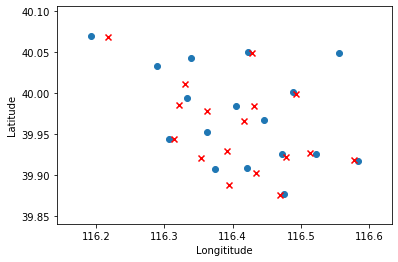

In [50]:
from matplotlib import pyplot as plt
#kmeans.cluster_centers_[ :,1]
ax=plt.subplot(1,1,1)
plot_num_estimators1 = []
plot_num_estimators1 =kmeans.cluster_centers_[ :,1]
plot_result_accuracy1 = []
plot_result_accuracy1 = kmeans.cluster_centers_[ :,0]
ax.scatter(plot_num_estimators1, plot_result_accuracy1)#kmeans
ax.scatter(combine_lg,combine_lt,c = 'r',marker = 'x')#cplex
ax.margins(0.1)
plt.ylabel('Latitude')
plt.xlabel('Longititude')
plt.show()  #因为有简化过所以多多少少有跑掉 #cplex分區 v.s kmeans不分區

In [52]:
import folium
map_osm = folium.Map(location=[39.992, 116.32], zoom_start=12)
for i in range(0,len(plot_num_estimators1)):
    folium.Marker([plot_result_accuracy1[i], plot_num_estimators1[i]], icon=folium.Icon(color='blue',icon='info-sign')).add_to(map_osm)

for i in range(0,len(combine_lg)):
    folium.Marker([combine_lt[i], combine_lg[i]],icon=folium.Icon(color='red',icon='cloud')).add_to(map_osm)

map_osm #red_kmeans # blue_cplex

In [53]:
process_tmp1=[]
process_tmp2=[]
process_tmp3=[]
for index, value in label_tmp.items():
        if value == "海淀区" :#提取出某天pm2.5了
            zero_tmp1=teams_area.iloc[index].copy().values
            process_tmp1.append(zero_tmp1)
zero_tmp1=pd.DataFrame(process_tmp1,columns=v)
print(zero_tmp1.shape)
print(zero_tmp1.head(5))
           
for index, value in label_tmp.items():
        if  value == "东城区" or value == "西城区":#提取出某天pm2.5了
            zero_tmp2=teams_area.iloc[index].copy().values
            process_tmp2.append(zero_tmp2)
zero_tmp2=pd.DataFrame(process_tmp2,columns=v)
print(zero_tmp2.shape)
print(zero_tmp2.head(5))

for index, value in label_tmp.items():
        if value == "朝阳区" :#提取出某天pm2.5了
            zero_tmp3=teams_area.iloc[index].copy().values
            process_tmp3.append(zero_tmp3)
zero_tmp3=pd.DataFrame(process_tmp3,columns=v)
print(zero_tmp3.shape)
print(zero_tmp3.head(5))

(94, 4)
  area         name        lat         lng
0  海淀区      中国国家图书馆  39.949641  116.330065
1  海淀区       海淀区图书馆  39.984178  116.315950
2  海淀区  中国科学院文献情报中心  39.993046  116.329603
3  海淀区   清华大学法律图书馆楼  40.005203  116.335359
4  海淀区     北京大学-图书馆  39.997899  116.316801
(74, 4)
  area         name        lat         lng
0  西城区       北京图书大厦  39.914075  116.383456
1  西城区  西城区青少年儿童图书馆  39.947947  116.376640
2  西城区      红楼公共藏书楼  39.928127  116.380154
3  西城区     西城区第二图书馆  39.894226  116.374833
4  东城区        角楼图书馆  39.878040  116.449567
(127, 4)
  area           name        lat         lng
0  朝阳区          首都图书馆  39.875885  116.469182
1  朝阳区  朝阳区图书馆(朝外小庄店)  39.922647  116.477617
2  朝阳区       杂书馆(国学馆)  40.043519  116.499623
3  朝阳区       朝阳区少儿图书馆  39.974269  116.407531
4  朝阳区  北京市朝阳区望京街道图书馆  40.000093  116.475464


In [54]:
team1_kmeans=zero_tmp1.drop(columns=['name','area']).copy()
data1_train=team1_kmeans
print(data1_train.head(5))

team2_kmeans=zero_tmp2.drop(columns=['name','area']).copy()
data2_train=team2_kmeans
print(data2_train.head(5))

team3_kmeans=zero_tmp3.drop(columns=['name','area']).copy()
data3_train=team3_kmeans
print(data3_train.head(5))

         lat         lng
0  39.949641  116.330065
1  39.984178  116.315950
2  39.993046  116.329603
3  40.005203  116.335359
4  39.997899  116.316801
         lat         lng
0  39.914075  116.383456
1  39.947947  116.376640
2  39.928127  116.380154
3  39.894226  116.374833
4  39.878040  116.449567
         lat         lng
0  39.875885  116.469182
1  39.922647  116.477617
2  40.043519  116.499623
3  39.974269  116.407531
4  40.000093  116.475464


In [55]:
kmeans=KMeans(n_clusters=5,random_state=0)
group1=kmeans.fit(data1_train)

kmeans=KMeans(n_clusters=5,random_state=0)
group2=kmeans.fit(data2_train)

kmeans=KMeans(n_clusters=7,random_state=0)
group3=kmeans.fit(data3_train)

In [56]:
print(group1.cluster_centers_[:,0])
print(group1.cluster_centers_[:,1])
print(group2.cluster_centers_[:,0])
print(group2.cluster_centers_[:,1])
print(group3.cluster_centers_[:,0])
print(group3.cluster_centers_[:,1])

[39.98016036 39.9995715  39.943477   40.06999975 40.0496797 ]
[116.35719191 116.31845287 116.30894225 116.19259425 116.3292353 ]
[39.95569614 39.89706794 39.90767426 39.94362425 39.91891443]
[116.43266057 116.38742456 116.42883258 116.39069512 116.35203771]
[39.8767545  39.925412   39.98408763 40.00882483 39.91751706 40.04734157
 39.93577264]
[116.47640719 116.52255724 116.42135413 116.49618579 116.58273441
 116.42792443 116.47249609]


In [57]:
group_lt=np.concatenate((group1.cluster_centers_[:,0],group2.cluster_centers_[:,0],group3.cluster_centers_[:,0]),axis=0).copy()
print(group_lt)
group_lg=np.concatenate((group1.cluster_centers_[:,1],group2.cluster_centers_[:,1],group3.cluster_centers_[:,1]), axis=0).copy()
print(group_lg)

[39.98016036 39.9995715  39.943477   40.06999975 40.0496797  39.95569614
 39.89706794 39.90767426 39.94362425 39.91891443 39.8767545  39.925412
 39.98408763 40.00882483 39.91751706 40.04734157 39.93577264]
[116.35719191 116.31845287 116.30894225 116.19259425 116.3292353
 116.43266057 116.38742456 116.42883258 116.39069512 116.35203771
 116.47640719 116.52255724 116.42135413 116.49618579 116.58273441
 116.42792443 116.47249609]


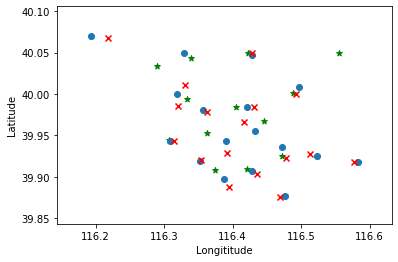

In [58]:
from matplotlib import pyplot as plt
#kmeans.cluster_centers_[ :,1]
ax=plt.subplot(1,1,1)
ax.scatter(plot_num_estimators1, plot_result_accuracy1,c = 'g',marker = '*')#kmeans不分區
ax.scatter(group_lg, group_lt)#kmeans分區
ax.scatter(combine_lg,combine_lt,c = 'r',marker = 'x')#cplex
ax.margins(0.1)
plt.ylabel('Latitude')
plt.xlabel('Longititude')
plt.show()  #因为有简化过所以多多少少有跑掉 #cplex分區 v.s kmeans分區

In [59]:
import folium
map_osm = folium.Map(location=[39.992, 116.32], zoom_start=12)
for i in range(0,len(plot_num_estimators1)):
    folium.Marker([plot_result_accuracy1[i], plot_num_estimators1[i]], icon=folium.Icon(color='green',icon='info-sign')).add_to(map_osm)

for i in range(0,len(combine_lg)):
    folium.Marker([combine_lt[i], combine_lg[i]],icon=folium.Icon(color='red',icon='cloud')).add_to(map_osm)

for i in range(0,len(group_lg)):
    folium.Marker([group_lt[i], group_lg[i]],icon=folium.Icon(color='blue',icon='cloud')).add_to(map_osm)
    
map_osm #green_kmeans不分區  #blue_kmeans分區 #red_cplex

In [60]:
from math import sqrt
kmeans_nosperate = np.concatenate((plot_num_estimators1, plot_result_accuracy1),axis=0).copy()
kmeans_sperate = np.concatenate((group_lg,  group_lt),axis=0).copy()
cplexAns = np.concatenate((combine_lg, combine_lt),axis=0).copy()
print(kmeans_nosperate)
print(kmeans_sperate)
print(cplexAns)
distances1=np.linalg.norm(cplexAns - kmeans_sperate, axis=0)
print(distances1)  #小
distances2=np.linalg.norm(cplexAns - kmeans_nosperate, axis=0)
print(distances2)  #大
#兩個都是分區結果會比較接近，但這樣算會有問題因為資料沒有排序過

[116.47186528 116.30680488 116.40453178 116.28919    116.58273441
 116.37375417 116.47469276 116.55584233 116.4456513  116.19259425
 116.48791559 116.33848817 116.42146796 116.33371257 116.36256541
 116.52255724 116.42258788  39.925688    39.94412704  39.98478111
  40.03334687  39.91751706  39.90789817  39.87654282  40.04883233
  39.96786355  40.06999975  40.00143014  40.04348167  39.90916057
  39.99412322  39.95294323  39.925412    40.04999525]
[116.35719191 116.31845287 116.30894225 116.19259425 116.3292353
 116.43266057 116.38742456 116.42883258 116.39069512 116.35203771
 116.47640719 116.52255724 116.42135413 116.49618579 116.58273441
 116.42792443 116.47249609  39.98016036  39.9995715   39.943477
  40.06999975  40.0496797   39.95569614  39.89706794  39.90767426
  39.94362425  39.91891443  39.8767545   39.925412    39.98408763
  40.00882483  39.91751706  40.04734157  39.93577264]
[116.363028 116.217388 116.320888 116.314693 116.330721 116.416827
 116.353041 116.394315 116.391726 11